## 5.2. 합성곱 신경망 맛보기

In [1]:
# fachion_mnist 데이터셋 사용 (운동화, 셔츠, 샌들 같은 작은 이미지의 모음)
# 28x28 픽셀의 이미지 7만 개로 구성되어 있음
# 훈련 데이터: 0~255 사이의 값을 갖는 28x28 크기의 NumPy 배열
# 레이블(정답) 데이터: 0~9 사이의 정수 값을 가지는 배열

# (코드 5-1) 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위한 라이브러리
from torch.utils.data import Dataset, DataLoader

c:\Users\USER\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\USER\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 파이토지는 기본적으로 GPU 사용 권장
# GPU 가 없으면 CPU를 사용하는 코드

# (코드 5-2) CPU 혹은 GPU 장치 확인
device = torch.device("cude:0" if torch.cuda.is_available() else "cpu")

In [3]:
# (코드 5-3) fashion_mnist 데이터셋 내려받기
# "./data"   >>  해당 파일 안에 FashionMNIST 폴더 생성
# download: True로 변경해주면, 첫 번째 파라미터의 위치에 해당 데이터셋이 있는지 확인 후 내려받음
# transform: 이미지를 텐서(0~1)로 변경
train_dataset = torchvision.datasets.FashionMNIST("./data", download=True, transform=transforms.Compose([transforms.ToTensor()]))

# 앞에서 훈련 데이터 셋을 내려받았다면, 여기서는 test dataset을 내려받음
test_dataset = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [4]:
# (코드 5-4) 내려받은 fashion_mnist 데이터를 메모리로 불러오기 위해 DataLoader에 전달
# torch.utils.data.DataLoader(데이터를 불러올 데이터셋, 100개 단위로 데이터 묶어서 불러옴)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

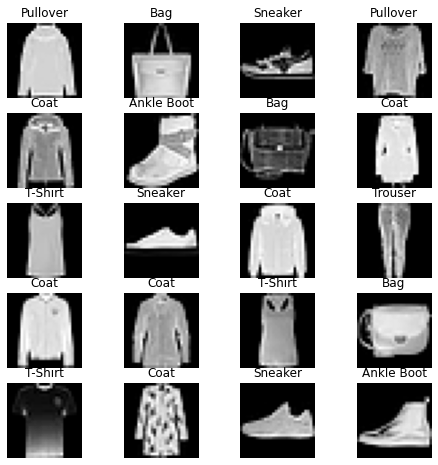

In [5]:
#################### 아래 코드 두 줄 삽입 ㅠㅠ >> 안 하면 Kernel이 충돌해서 오류 뜸...######################
# 참고 링크: https://normal-engineer.tistory.com/236
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
##########################################################################################################

# (코드 5-5) 분류에 사용될 클래스 정의
labels_map = {0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

# 출력할 이미지의 가로 세로 길이로 단위는 inch
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:] # train_dataset에서 해당하는 요소의 값 가져온다는 의미
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

# 20개의 이미지 데이터를 시각적으로 표현
plt.show()

#### 5.2.1. 심층 신경망

In [8]:
# (코드 5-6) 심층 신경망 모델 생성 (즉, ConvNet이 적용되지 않은 네트워크)
# 합성곱 신경망과의 비교를 위해 먼저 심층 신경망 생성

class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        
        # nn: 딥러닝 모델 구성에 필요한 모듈이 모여 있는 패키지
        # Linear: 단순 선형 회귀 모델 때 사용
        # nn.Linear(입력 크기, 출력 크기)
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        
        # nn.Dropout(0.25): 0.25만큼의 비율로 텐서 값이 0이 됨
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
    
    # forward(): 모델이 학습 데이터를 입력받아 순전파 학습 진행 (함수명은 반드시 forward)
    def forward(self, input_data):
        # 파이토치의 view >> 넘파이의 reshape와 같은 역할 >> 텐서의 크기를 변경해주는 역할
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [7]:
########## [참고] 클래스 코드 연습 ##########
class Calc:
    def __init__(self): # 객체를 생성할 때 호출하면 실행되는 초기화 함수
        self.result = 0
    def add(self, num1, num2):
        self.result = num1 + num2
        return self.result
    
# 실행
obj1 = Calc()
obj2 = Calc()

print(obj1.add(1,2))
print(obj1.add(2,3))
print()
print(obj2.add(2,2))
print(obj2.add(2,3))
############################################

3
5

4
5


In [9]:
# (코드 5-7) 심층 신경망에서 필요한 파라미터 정의
# 손실함수 / 학습률(learning rate) / 옵티마이저(optimizer)
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류에서 사용하는 손실함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate); # 옵티마이저를 위한 경사 하강법은 Adam을 사용
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
# (코드 5-8) 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        outputs = model(train) # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        # count를 50으로 나눴을 때 나머지가 0이 아니면 실행
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not(count % 500):
            print(f"Ieration: {count}, Loss: {loss.data:.2f}, Accuracy: {accuracy:.2f}%")

# 결과 해석
# 최종적으로 정확도가 86%로 높은 수치 보여줌

Ieration: 500, Loss: 0.56, Accuracy: 83.30%
Ieration: 1000, Loss: 0.49, Accuracy: 84.12%
Ieration: 1500, Loss: 0.38, Accuracy: 84.96%
Ieration: 2000, Loss: 0.38, Accuracy: 85.33%
Ieration: 2500, Loss: 0.27, Accuracy: 86.06%
Ieration: 3000, Loss: 0.31, Accuracy: 86.81%


#### 5.2.2. 합성곱 신경망

In [11]:
# (코드 5-9) 합성곱 신경망 (합성곱 네트워크 생성)
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 각 배치 단위별로 데이터가 다양한 분포를 가지더라도, 평균&분산을 이용하여 정규화하는 것
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 이미지 크기를 축소하는 용도
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10) # 마지막 계층의 out_features는 클래스 개수를 의미
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        # 합성곱층에서 완전 연결층으로 변형되므로 데이터의 형태를 1차원으로 바꿔줌
        # out.size(0) 은 100을 의미 >> (100,?)의 크기로 텐서를 변경하겠다는 의미
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [12]:
# (코드 5-10) 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [13]:
# (코드 5-11) 모델 학습 및 성능 평가
# (코드 5-8 과 동일한 코드)

num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not(count % 500):
            print(f"Ieration: {count}, Loss: {loss.data:.2f}, Accuracy: {accuracy:.2f}%")

# 결과 해석
# '심층 신경망'에서의 정확도: 86%
# '합성곱 신경망'에서의 정확도:
# 합성곱 신경망에서의 정확도가 심층 신경망에 비해 약간 높음
# BUT 실제로 이미지 데이터가 많아지면 단순 심층 신경망으로는 정확한 특성 추출 및 분류가 불가능하므로 '합성곱 신경망'을 생성해야 함!!

Ieration: 500, Loss: 0.51, Accuracy: 87.76%
Ieration: 1000, Loss: 0.34, Accuracy: 87.64%
Ieration: 1500, Loss: 0.31, Accuracy: 87.52%
Ieration: 2000, Loss: 0.22, Accuracy: 90.06%
Ieration: 2500, Loss: 0.18, Accuracy: 89.73%
Ieration: 3000, Loss: 0.23, Accuracy: 89.95%


## 5.3. 전이 학습

In [ ]:
# 합성곱 신경망 기반 딥러닝 모델 >> 많은 양의 데이터 필요
# 큰 데이터셋을 확보하기 위한 어려움 극복한 것 >> 전이 학습 (Transfer Learning)
# 전이 학습의 방법: 특성 추출 기법 & 미세 조정 기법

#### 5.3.1. 특성 추출 기법

In [1]:
# 특성 추출 (Feature Extractor)
# ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만듦
# 사용 가능한 모델: Xception, Inception V3, ResNet50, VGG16, VGG19, MobileNet

# prompt에서 pip install opencv-python 해줌

# (코드 5-12) 라이브러리 호출
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms # 데이터 전처리 용도
import torchvision.models as models # 다양한 파이토치 네트워크 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

c:\Users\USER\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\USER\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# (코드 5-13) 예제에서 사용할 이미지 데이터 전처리 방법 정의
# 이미지 데이터가 위치한 경로 지정
data_path = "./data/catanddog/train"

transform = transforms.Compose(
    [
        # 이미지 크기를 256x256으로 조정 >> 합성곱층을 통과하기 위해 이미지 크기 조정
        transforms.Resize([256, 256]),
        
        # 이미지를 랜덤한 크기.비율로 자름 >> 데이터 확장 용도 (랜덤한 비율로 자른 후 데이터 크기 조정)
        transforms.RandomResizedCrop(224), 
        
        # 이미지를 랜덤하게 수평으로 뒤집음
        transforms.RandomHorizontalFlip(),
        
        # 이미지 데이터를 텐서로 변환
        transforms.ToTensor()
])

# datasets.ImageFolder >> 데이터로더가 데이터를 불러올 대상 & 방법 정의
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform # 이미지 데이터에 대한 전처리
)

# DataLoader >> 데이터를 불러옴
train_loader = torch.utils.data.DataLoader(
    train_dataset,   # 데이터셋 지정
    batch_size = 32, # batch_size: 한 번에 불러올 데이터양 결정
    num_workers = 8, # 데이터를 불러올 때 하위 프로세스를 몇 개 사용할지 설정 (**주의: 너무 많은 하위 프로세스 설정 시 오류 발생 or 메모리 부족 현상 발생)
    shuffle = True # 데이터를 무작위로 섞어서 랜덤으로 불러올 것
)

# train_dataset에 포함된 데이터 개수 출력 결과
print(len(train_dataset))

385


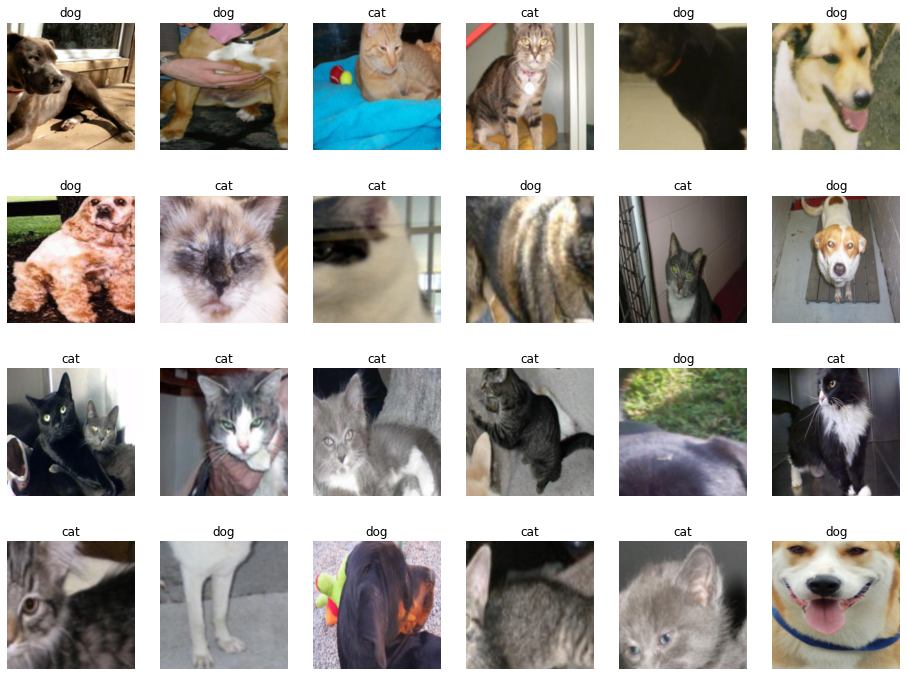

In [5]:
###############(Kernel 충돌 방지)################
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#################################################

# (코드 5-14) 학습에 사용될 이미지 출력
# 24개의 이미지에 대해 레이블 정보와 함께 출력

import numpy as np

# 반복자(for 구문과 같은 효과)를 사용하려면 iter()와 next() 필요
# iter(): 전달된 데이터의 반복자를 꺼내 반환
# next(): 그 반복자가 다음에 출력해야 할 요소 반환
samples, labels = iter(train_loader).next()

classes = {0:'cat', 1:'dog'} # 개, 고양이 클래스 구성
fig = plt.figure(figsize=(16,24))

# 24개의 이미지 데이터 출력
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()]) # 레이블 정보(클래스)를 함께 출력
    a.axis("off")
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


In [7]:
# 참고
# 데이터 형태 확인
print(samples.shape)

# 행렬 차원 변경 후 형태 확인
print(np.transpose(samples).shape)

# 행, 열의 수가 달라 내적이 불가능할 때는 대비해서 차원 조정
# np.transpose()   또는    np.reshape()

torch.Size([32, 3, 224, 224])
torch.Size([224, 224, 3, 32])


In [8]:
# (코드 5-15) 사전에 훈련된 모델 내려 받기 (ResNet18 모델)
# ResNet18 모델: 50개의 계층으로 구성된 합성곱 신경망
# pretrained=True >> 사전 학습된 가중치를 사용하겠다는 의미
resnet18 = models.resnet18(pretrained=True)

In [9]:
# (코드 5-16) 사전 훈련된 모델의 파라미터 학습 유무 지정
# 내려받은 ResNet18의 합성곱층을 사용하되, 파라미터에 대해서는 학습하지 않도록 고정
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 역전파 중 파라미터들에 대한 변화 계산 불필요
set_parameter_requires_grad(resnet18)

In [10]:
# (코드 5-17) ResNet18에 완전연결층 추가 (: 개, 고양이 클래스 분류 용도)
resnet18.fc = nn.Linear(512,2) # 2: 클래스가 두 개라는 의미

In [11]:
# (코드 5-18) 모델의 파라미터 값 확인
# 모델명.named_parameters() >> 해당 모델에 접근하여 파라미터 값들을 가져올 때 사용
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

# 실행 결과
# 파라미터는 weight와 bias가 사용되고 있음

fc.weight tensor([[ 0.0034, -0.0304, -0.0234,  ..., -0.0416,  0.0222,  0.0209],
        [-0.0437,  0.0104,  0.0130,  ...,  0.0075, -0.0403, -0.0399]])
fc.bias tensor([-0.0374, -0.0195])


In [12]:
# (코드 5-19) 모델 객체 생성 및 손실 함수 정의
# 모델 객체 생성
model = models.resnet18(pretrained=True)

# 모델의 합성곱층 가중치 >> 고정
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
# 완전 연결층 >> 학습
for param in model.fc.parameters():
    param.requires_grad =True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss() # 손실함수 정의
print(model)

# 이로써 데이터 준비 및 네트워크 생성 완료됨 >> 이제 모델 학습시켜야 함

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# (코드 5-20) 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time() # 컴퓨터의 현재 시각 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs): # 지정된 epoch(13) 만큼 반복
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-"*10)
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders: # 데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad() # 기울기 0으로 설정
            outputs = model(inputs) # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() # 역전파 학습
            optimizer.step()
            
            # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_loss += (loss.item() * inputs.size(0))
            # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss/len(dataloaders.dataset) # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산
        
        print(f"Loss: {epoch_loss:.4f}     Acc: {epoch_acc:.4f}")
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('./data/catanddog/', "{0:0=2d}.pth".format(epoch))) # 모델 재사용을 위해 저장해 둠
        
        print()
        
    time_elapsed = time.time() - since # 실행 시간(학습 시간)을 계산
    print(f"Training complete in {time_elapsed//60 :.0f}m {time_elapsed%60 :.0f}s")
    print(f"Best Acc: {best_acc:.4f}")
    
    # 모델의 정확도와 오차 반환
    return acc_history, loss_history

In [31]:
# (코드 5-21) 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

# 학습 결과를 optimizer에 전달
optimizer = optim.Adam(params_to_update)

# 실행 결과
# 완전 연결층의 어떤 파라미터들이 옵티마이저로 전달되는지 보여줌
# weight와 bias 값들이 업데이트되고 옵티마이저에 전달됨을 의미

	 fc.weight
	 fc.bias


In [32]:
# (코드 5-22) 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss() # 손실 함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device, num_epochs=13, is_train=True)

# 결과
# 약 91%로 높은 정확도 보여줌

Epoch 0/12
----------
Loss: 0.5004     Acc: 0.7870

Epoch 1/12
----------
Loss: 0.3756     Acc: 0.8468

Epoch 2/12
----------
Loss: 0.3031     Acc: 0.8857

Epoch 3/12
----------
Loss: 0.3096     Acc: 0.8545

Epoch 4/12
----------
Loss: 0.2481     Acc: 0.9065

Epoch 5/12
----------
Loss: 0.3047     Acc: 0.8442

Epoch 6/12
----------
Loss: 0.3457     Acc: 0.8442

Epoch 7/12
----------
Loss: 0.1997     Acc: 0.9091

Epoch 8/12
----------
Loss: 0.2034     Acc: 0.9247

Epoch 9/12
----------
Loss: 0.1978     Acc: 0.9091

Epoch 10/12
----------
Loss: 0.2499     Acc: 0.8909

Epoch 11/12
----------
Loss: 0.2729     Acc: 0.8545

Epoch 12/12
----------
Loss: 0.2043     Acc: 0.9117

Training complete in 5m 5s
Best Acc: 0.9247


In [33]:
# (코드 5-23) test data 호출 및 전처리
test_path = "./data/catanddog/test"

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [34]:
# (코드 5-24) 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0
    
    # glob >> 현재 디렉터리에서 원하는 파일들만 추출하여 가져올 때 사용
    # 해당 경로에서 pth 확장자를 갖는 파일을 가져오라는 의미
    saved_models = glob.glob("./data/catanddog/" + "*.pth")
    saved_models.sort() # 불러온 .pth 파일들을 정렬
    print("saved_model", saved_models)
    
    for model_path in saved_models:
        print("Loading model", model_path)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0
        
        # 테스트 반복
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad(): # autograd를 사용하지 않겠다는 의미
                outputs = model(inputs) # 데이터를 모델에 적용한 결과를 outpus에 저장
            
            # torch.max: 주어진 텐서 배열의 최댓값이 들어 있는 index를 반환하는 함수
            _, preds = torch.max(outputs.data, 1)
            # torch.max로 출력된 값이 0.5보다 크면 올바르게 예측
            preds[preds >= 0.5] = 1
            # torch.max로 출력된 값이 0.5보다 작으면 틀리게 예측
            preds[preds < 0.5] = 0
            
            # preds.eq(labels) >> preds 배열과 labels가 일치하는지 검사하는 용도
            # .sum()을 해줌으로써 일치하는 것들의 개수 합을 숫자로 출력
            running_corrects += preds.eq(labels.cpu()).int().sum()
        
        # test data의 정확도 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f"Acc: {epoch_acc:.4f}")
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        print()
    
    time_elapsed = time.time() - since
    print(f"Validation complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Acc: {best_acc:.4f}")
    
    # 계산된 정확도 반환
    return acc_history

In [35]:
# (코드 5-25) 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

# 결과 해석
# 약 96%의 높은 정확도

saved_model ['./data/catanddog\\00.pth', './data/catanddog\\01.pth', './data/catanddog\\02.pth', './data/catanddog\\03.pth', './data/catanddog\\04.pth', './data/catanddog\\05.pth', './data/catanddog\\06.pth', './data/catanddog\\07.pth', './data/catanddog\\08.pth', './data/catanddog\\09.pth', './data/catanddog\\10.pth', './data/catanddog\\11.pth', './data/catanddog\\12.pth']
Loading model ./data/catanddog\00.pth
Acc: 0.8571

Loading model ./data/catanddog\01.pth
Acc: 0.9082

Loading model ./data/catanddog\02.pth
Acc: 0.8980

Loading model ./data/catanddog\03.pth
Acc: 0.9286

Loading model ./data/catanddog\04.pth
Acc: 0.9490

Loading model ./data/catanddog\05.pth
Acc: 0.9286

Loading model ./data/catanddog\06.pth
Acc: 0.9388

Loading model ./data/catanddog\07.pth
Acc: 0.9082

Loading model ./data/catanddog\08.pth
Acc: 0.9592

Loading model ./data/catanddog\09.pth
Acc: 0.9592

Loading model ./data/catanddog\10.pth
Acc: 0.9694

Loading model ./data/catanddog\11.pth
Acc: 0.9082

Loading mod

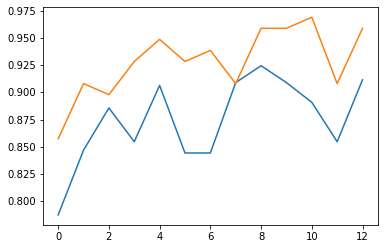

In [36]:
# (코드 5-26) 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

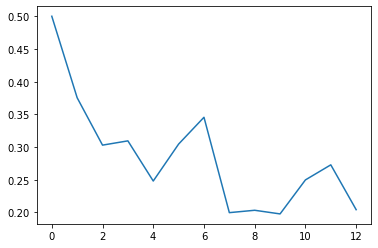

In [37]:
# (코드 5-27) 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

# 데이터에 대해 epoch가 진행될 때마다 오차를 출력한 결과
# epoch가 진행될수록 오차가 낮아지고 있으므로 학습이 잘 됐다고 할 수 있음!

In [39]:
# (코드 5-28) 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)
    return image

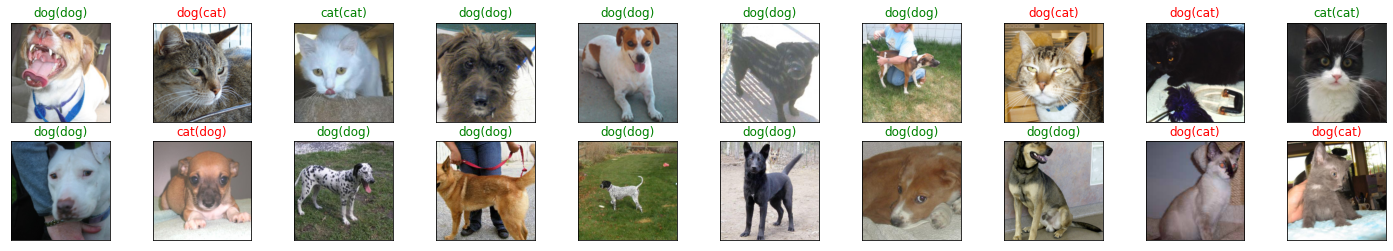

<Figure size 432x288 with 0 Axes>

In [41]:
# (코드 5-29) 개와 고양이 예측 결과 출력
# 개와 고양이 두 개에 대한 레이블
classes = {0:'cat', 1:'dog'}

# test dataset 가져옴
dataiter = iter(test_loader)
# 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져옴
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output,1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    # add_subplot: 한 화면에 여러 개의 이미지를 담기 위해 사용
    # add_subplot(행의 수, 열의 수, 인덱스, tick 삭제)
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx])) #이미지 출력을 위해 (코드 5-28)에서 정의한 im_convert 함수 적용
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))

plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

# 초록색: 예측 잘 됨
# 빨간색: 예측 잘못 됨

# 훈련 데이터를 더 늘리고, epoch 횟수도 더 늘려보면 좋은 결과 얻을 수 있을 것

#### 5.3.2. 미세 조정 기법 (fine-tuning)

In [ ]:
# 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식
# 특성 추출 >> 목표 특성을 잘 추출했다는 전제 하에 좋은 성능
# 특성이 잘못 추출되면? >> 이 때 미세 조정 기법으로 새로운 이미지 데이터를 사용하여 네트워크의 가중치를 업데이트해서 특성을 다시 추출할 수 있음

## 5.4. 설명 가능한 CNN (explainable CNN)
* 딥러닝 처리 결과를 사람이 이해할 수 있는 방식으로 제시하는 기술
* CNN 처리 과정을 시각화할 필요성 있음 (내부에서 어떻게 동작하는지 알기 위함)
* CNN 시각화 방법: 1) 필터에 대한 시각화, 2) 특성 맵에 대한 시각화

#### 5.4.1. 특성 맵 시각화 (feature map)

In [1]:
# 이미지 분석 및 처리를 쉽게 할 수 있도록 도와주는 라이브러리: PIL 설치
# PIL (Python Image Library)

!pip install pillow

In [1]:
# (코드 5-30) 필요한 라이브러리 호출
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\USER\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\USER\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 설명 가능한 모델을 위해 ReLU 를 이용해서 13개의 합성곱층과 두 개의 완전연결층으로 구성된 네트워크 생성

# (코드 5-31) 설명 가능한 네트워크 생성
class XAI(torch.nn.Module):
    def __init__(self, num_class=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), # inplace=True: 기존의 데이터를 연산의 결괏값으로 대체
            nn.Dropout(0.3),
            nn.Conv2d(64,64,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), # inplace=True: 기존의 데이터를 연산의 결괏값으로 대체
            nn.Dropout(0.4),
            nn.Conv2d(128,128,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), # inplace=True: 기존의 데이터를 연산의 결괏값으로 대체
            nn.Dropout(0.4),
            nn.Conv2d(256,256,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256,256,kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), # inplace=True: 기존의 데이터를 연산의 결괏값으로 대체
            nn.Dropout(0.4),
            nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True), # inplace=True: 기존의 데이터를 연산의 결괏값으로 대체
            nn.Dropout(0.4),
            nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512,kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_class)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)
        # log_softmax() : 신경망 말단의 결괏값들을 확률 개념으로 해석하기 위해 softmax 함수 결과에 log 값 취한 연산
        # Softmax가 기울기 소멸 문제(vanishing gradient problem)에 취약하기 때문에 lof_softmax() 사용

In [3]:
# (코드 5-32) 모델 객체화
# 생성한 모델을 객체화한 후 장치(GPU 혹은 CPU)에 할당
model = XAI() # model이라는 이름의 객체 생성
model.to(device) # model을 장치에 할당
model.eval() # test data에 대한 모델 평가 용도로 사용

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [4]:
# (코드 5-33) 특성 맵을 확인하기 위한 클래스 정의
class LayerActivations:
    features = []
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()
    
    def remove(self): # hook 삭제
        self.hook.remove()

torch.Size([1, 3, 100, 100])


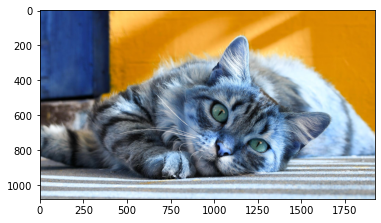

In [5]:
#################### 아래 코드 두 줄 삽입 ㅠㅠ >> 안 하면 Kernel이 충돌해서 오류 뜸...######################
# 참고 링크: https://normal-engineer.tistory.com/236
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'
##########################################################################################################

# (코드 5-34) 이미지 호출
img = cv2.imread("./data/cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)

# unsqueeze() : 1차원 데이터를 생성하는 함수
# 이미지 데이터를 텐서로 변환 -> 변환된 데이터를 1차원으로 변경
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

In [6]:
# (코드 5-35) (0): Conv2d 특성 맵 확인
# (코드 5-32)의 출력 결과인 (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False) 에 대한 특성 맵 확인

result = LayerActivations(model.features, 0) # 0번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

C:\Users\USER\AppData\Local\Temp\ipykernel_10592\2500098828.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


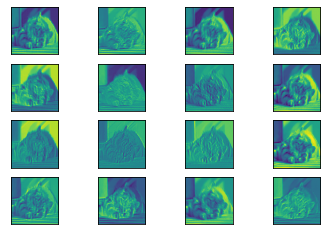

<Figure size 864x576 with 0 Axes>

In [7]:
# (코드 5-36) 특성 맵 확인 (특성 맵을 시각적으로 표현)
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10 + column])
plt.show()

# 출력 결과: 첫 번째 Conv2d 계층에서 특성 맵에 대한 출력 결과
# 입력층과 가까운 계층으로 입력 이미지의 형태가 많이 유지되고 있음

C:\Users\USER\AppData\Local\Temp\ipykernel_10592\2500098828.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


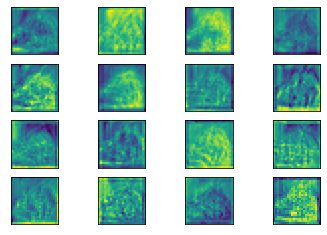

<Figure size 864x576 with 0 Axes>

In [8]:
# 20번째 계층에 대한 특성 맵

# (코드 5-37) 20번째 계층에 대한 특성 맵
result = LayerActivations(model.features, 20) # 20번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

# (코드 5-38) 특성 맵 확인
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10 + column])
plt.show()

# 출력 결과
# 20번째 특성 맵의 결과 기존 고양이 이미지의 형태는 찾아볼 수 없게 됨 ...

C:\Users\USER\AppData\Local\Temp\ipykernel_10592\2500098828.py:78: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


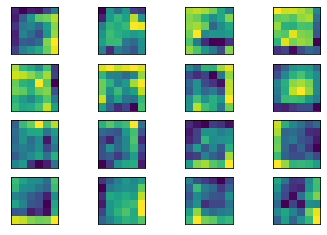

<Figure size 864x576 with 0 Axes>

In [9]:
# 40번째 계층에 대한 특성 맵

# (코드 5-39) 40번째 계층에 대한 특성 맵
result = LayerActivations(model.features, 40) # 20번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

# (코드 5-40) 특성 맵 확인
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10 + column])
plt.show()

# 출력 결과
# 40번째 특성 맵의 결과 기존 고양이 이미지의 형태는 전혀... 찾아볼 수 없게 됨 ...

# 즉, 출력층에 가깡ㄹ수록 원래 형태는 찾아볼 수 없고, 이미지 특징들만 전달됨

## [기타]

In [ ]:
############################################################################
# 아래는 p. 204의 부록 같은 코드인데, error가 해결되지 않음 ...

In [5]:
!pip install mxnet --user

  Using cached mxnet-1.7.0.post2-py2.py3-none-win_amd64.whl (33.1 MB)
  Using cached numpy-1.16.6.zip (5.1 MB)
  Using cached graphviz-0.8.4-py2.py3-none-any.whl (16 kB)
  Running setup.py clean for numpy
Failed to build numpy
    Running setup.py install for numpy: started
    Running setup.py install for numpy: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\USER\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\USER\\AppData\\Local\\Temp\\pip-install-2nmlhp8b\\numpy_27686c4b4e3a4107b8888aeb6b2f5995\\setup.py'"'"'; __file__='"'"'C:\\Users\\USER\\AppData\\Local\\Temp\\pip-install-2nmlhp8b\\numpy_27686c4b4e3a4107b8888aeb6b2f5995\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\USER\AppData\Local\Temp\pip-wheel-ocetxerc'
       cwd: C:\Users\USER\AppData\Local\Temp\pip-install-2nmlhp8b\numpy_27686c4b4e3a4107b8888aeb6b2f5995\
  Complete output (264 lines):
  Running from numpy source directory.
  C:\Users\USER\AppData\Local\Temp\pip-install-2nmlhp8b\numpy_27686c4b4e3a4107b8888ae

In [3]:
###################(p. 204) RandomResizedCrop 자세히 알아보기
# prompt에 pip install mxnet 해줌

import mxnet as mx

ModuleNotFoundError: No module named 'mxnet'